``plot_trace``関数でワーニングを出さないため次のコマンド実行が必要です。

In [1]:
#!pip install --upgrade numba | tail -n 1

##  5.3 階層ベイズモデル

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/notebooks/5_3_%E9%9A%8E%E5%B1%A4%E3%83%99%E3%82%A4%E3%82%BA%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 共通処理

In [2]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [3]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [4]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.11.0
Running on ArViz v0.17.1


### 5.3.1 問題設定
アイリスデータセットで３種類の花の回帰直線を同時に求める。  
データ数が少ないという条件の下で、３つの回帰直線は共通の傾向がある前提とする。  
この場合、階層ベイズモデルの問題に帰着する。


### 5.3.2 データ準備

####  アイリス・データセットの読み込みと内容の確認

In [5]:
# アイリスデータセットの読み込み
df = sns.load_dataset('iris')

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df['species'].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [6]:
df.head().to_excel('df.xlsx')

#### 目標とするデータの抽出

In [7]:
# setosaの行のみ抽出
df0 = df.query('species == "setosa"')

# versicolorの行のみ抽出
df1 = df.query('species == "versicolor"')

# virginicaの行のみ抽出
df2 = df.query('species == "virginica"')

# 乱数により3個のインデックスを生成
import random
random.seed(42)
indexes =range(len(df0))
sample_indexes=random.sample(indexes, 3)

# df0, df1, df2のデータ数をそれぞれ3行にする
df0_sel = df0.iloc[sample_indexes]
df1_sel = df1.iloc[sample_indexes]
df2_sel = df2.iloc[sample_indexes]

#　全部連結して一つにする
df_sel = pd.concat([df0_sel, df1_sel, df2_sel]).reset_index(drop=True)

#### 加工結果の確認

In [8]:
display(df_sel)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.000,3.500,1.300,0.300,setosa
1,5.000,3.400,1.500,0.200,setosa
2,4.900,3.000,1.400,0.200,setosa
3,5.500,2.600,4.400,1.200,versicolor
4,4.900,2.400,3.300,1.000,versicolor
5,6.400,3.200,4.500,1.500,versicolor
6,6.700,3.100,5.600,2.400,virginica
7,7.300,2.900,6.300,1.800,virginica
8,5.800,2.700,5.100,1.900,virginica


#### 散布図による抽出結果表示

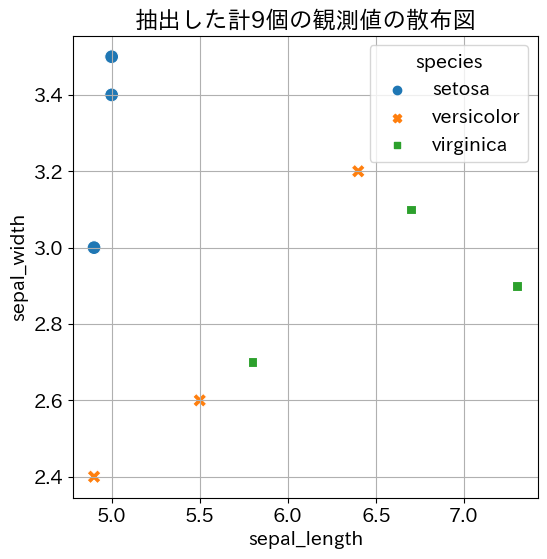

In [9]:
sns.scatterplot(
    x='sepal_length', y='sepal_width', hue='species', style='species',
    data=df_sel, s=100)
plt.title('抽出した計9個の観測値の散布図');

#### ベイス推論用変数の抽出

In [10]:
X = df_sel['sepal_length'].values
Y = df_sel['sepal_width'].values
species = df_sel['species']
cl = pd.Categorical(species).codes

# 結果確認
print(X)
print(Y)
print(species.values)
print(cl)

[5.000 5.000 4.900 5.500 4.900 6.400 6.700 7.300 5.800]
[3.500 3.400 3.000 2.600 2.400 3.200 3.100 2.900 2.700]
['setosa' 'setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor'
 'virginica' 'virginica' 'virginica']
[0 0 0 1 1 1 2 2 2]


### 5.3.3 確率モデル定義

#### 階層ベイズモデルの確率モデル定義

In [11]:
model1 = pm.Model()

with model1:
    # X, Yの観測値をConstantDataとして定義(通常ベイズと共通)
    X_data = pm.ConstantData('X_data', X)
    Y_data = pm.ConstantData('Y_data', Y)

    # クラス変数定義(階層ベイズ固有)
    cl_data = pm.ConstantData('cl_data', cl)

    # 確率変数alphaの定義(階層ベイズ固有)
    a_mu = pm.Normal('a_mu', mu=0.0, sigma=10.0)
    a_sigma = pm.HalfNormal('a_sigma',sigma=10.0)
    alpha = pm.Normal('alpha', mu=a_mu, sigma=a_sigma, shape=(3,))

    # 確率変数betaの定義(階層ベイズ固有)
    b_mu = pm.Normal('b_mu', mu=0.0, sigma=10.0)
    b_sigma = pm.HalfNormal('b_sigma', sigma=10.0)
    beta = pm.Normal('beta', mu=b_mu, sigma=b_sigma, shape=(3,))

    #　誤差epsilon(通常ベイスと共通)
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # muの値は、cl_dataによりindexを切り替えて計算(階層ベイズ固有)
    mu = pm.Deterministic('mu', X_data * alpha[cl_data] + beta[cl_data])

    # mu, epsilonを使って観測値用の確率モデルを定義(通常ベイスと共通)
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=Y_data)

#### PyMC変数をNumPy変数に置き換えた場合のmuの計算の仕組み

In [12]:
# ALPHAは要素数３の配列
ALPHA = np.array([0.1, 0.2, 0.3])
print(ALPHA)

# CLは要素数9の配列
CL = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
print(CL)

# MUも要素数9の配列になる
MU = ALPHA[CL]
print(MU)

[0.100 0.200 0.300]
[0 0 0 1 1 1 2 2 2]
[0.100 0.100 0.100 0.200 0.200 0.200 0.300 0.300 0.300]


#### 確率モデル構造可視化

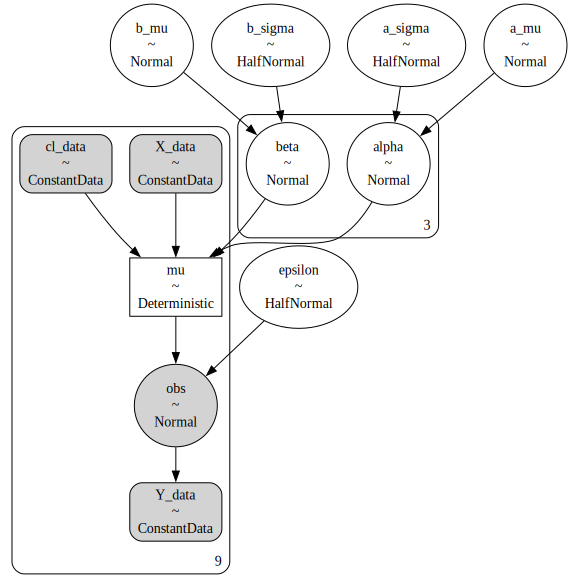

In [13]:
g = pm.model_to_graphviz(model1)
display(g)

### 5.3.4 サンプリングと結果分析

#### サンプリング

In [14]:
with model1:
    idata1 = pm.sample(random_seed=42, target_accept=0.998)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma, alpha, b_mu, b_sigma, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 257 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### plot_trace関数で推論結果の確認

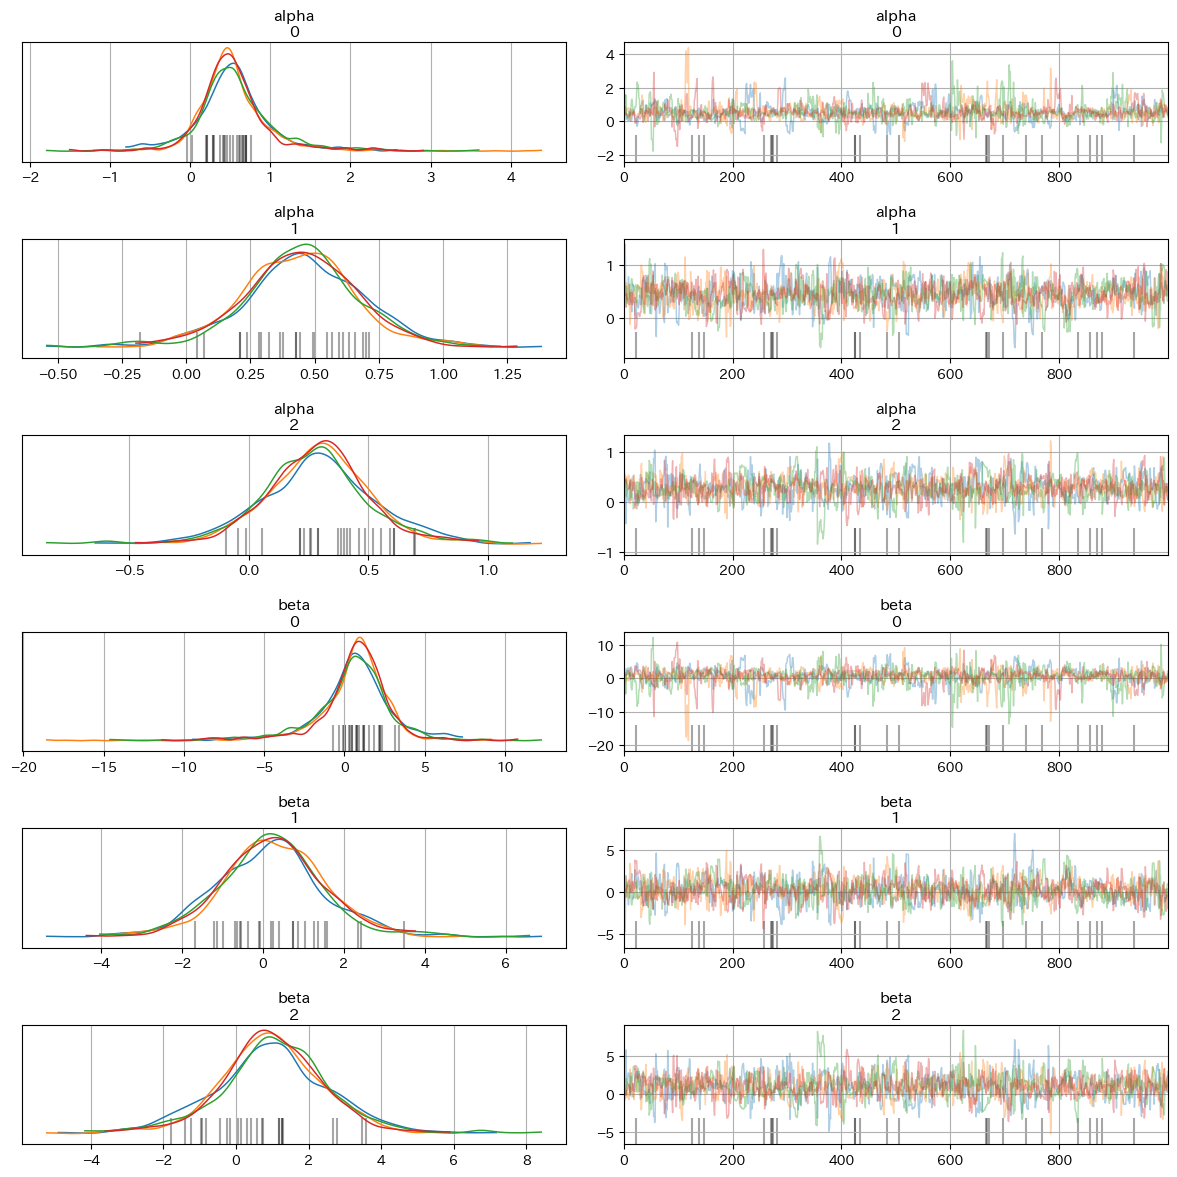

In [15]:
az.plot_trace(idata1, compact=False, var_names=['alpha', 'beta'])
plt.tight_layout();

#### summary関数で推論結果の確認

In [16]:
summary1 = az.summary(idata1, var_names=['alpha', 'beta'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.545,0.486,-0.298,1.577,0.017,0.013,865.000,763.000,1.000
alpha[1],0.448,0.232,-0.001,0.892,0.008,0.006,862.000,1265.000,1.000
alpha[2],0.287,0.230,-0.122,0.758,0.008,0.006,934.000,988.000,1.000
beta[0],0.581,2.418,-4.507,4.769,0.083,0.060,872.000,759.000,1.000
beta[1],0.232,1.318,-2.207,2.775,0.045,0.031,852.000,1240.000,1.000
beta[2],1.006,1.516,-2.030,3.758,0.050,0.041,929.000,935.000,1.000


### 5.3.5 散布図と回帰直線の重ね描き

#### 散布図と回帰直線の重ね描き

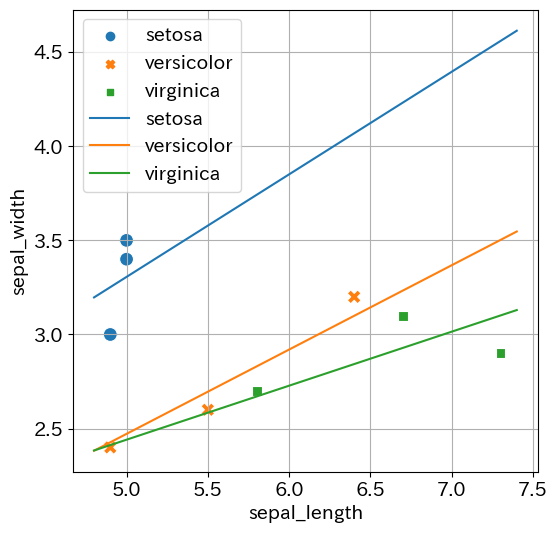

In [17]:
# alphaとbetaの平均値の導出
means = summary1['mean']
alpha0 = means['alpha[0]']
alpha1 = means['alpha[1]']
alpha2 = means['alpha[2]']
beta0 = means['beta[0]']
beta1 = means['beta[1]']
beta2 = means['beta[2]']

# 回帰直線用座標値の計算
x_range = np.array([X.min()-0.1,X.max()+0.1])
y0_range = alpha0 * x_range + beta0
y1_range = alpha1 * x_range + beta1
y2_range = alpha2 * x_range + beta2

# 散布図表示
sns.scatterplot(
    x='sepal_length', y='sepal_width', hue='species', style='species',
    data=df_sel, s=100)
plt.plot(x_range, y0_range, label='setosa')
plt.plot(x_range, y1_range, label='versicolor')
plt.plot(x_range, y2_range, label='virginica')
plt.legend();

#### オリジナルの散布図と回帰直線の重ね描き

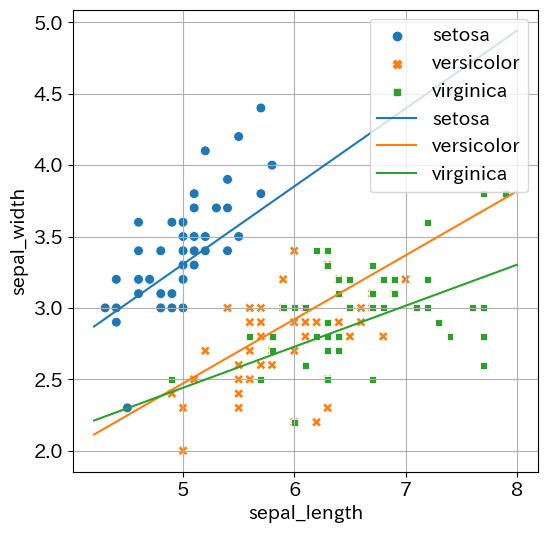

In [18]:
# 回帰直線の座標値計算
x_range = np.array([
    df['sepal_length'].min()-0.1,
    df['sepal_length'].max()+0.1])
y0_range = alpha0 * x_range + beta0
y1_range = alpha1 * x_range + beta1
y2_range = alpha2 * x_range + beta2

# 散布図表示
sns.scatterplot(
    x='sepal_length', y='sepal_width', hue='species', style='species',
    s=50, data=df)
plt.plot(x_range, y0_range, label='setosa')
plt.plot(x_range, y1_range, label='versicolor')
plt.plot(x_range, y2_range, label='virginica')
plt.legend();

### コラム　PyMCの構成要素はどこまで細かく定義すべきか

#### 確率変数の関係のみに着目した簡易的な方法

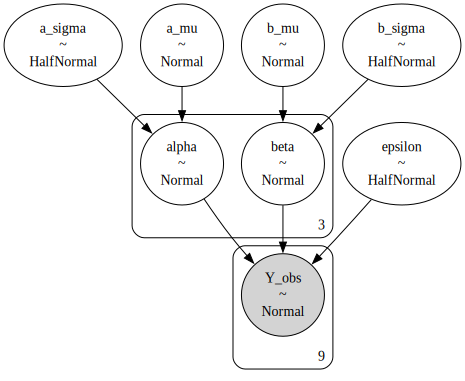

In [19]:
model2 = pm.Model()

with model2:
    # 確率変数alphaの定義(階層ベイズ固有)
    a_mu = pm.Normal('a_mu', mu=0.0, sigma=10.0)
    a_sigma = pm.HalfNormal('a_sigma',sigma=10.0)
    alpha = pm.Normal('alpha', mu=a_mu, sigma=a_sigma, shape=(3,))

    # 確率変数betaの定義(階層ベイズ固有)
    b_mu = pm.Normal('b_mu', mu=0.0, sigma=10.0)
    b_sigma = pm.HalfNormal('b_sigma', sigma=10.0)
    beta = pm.Normal('beta', mu=b_mu, sigma=b_sigma, shape=(3,))

    #　誤差epsilon(通常ベイスと共通)
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # muの値は、clによりindexを切り替えて計算(階層ベイズ固有)
    mu = X * alpha[cl] + beta[cl]

    # mu, epsilonを使って観測値用の確率モデルを定義(通常ベイスと共通)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=Y)

g = pm.model_to_graphviz(model2)
display(g)

#### 観測値や途中経過を含めたすべての計算過程を表現

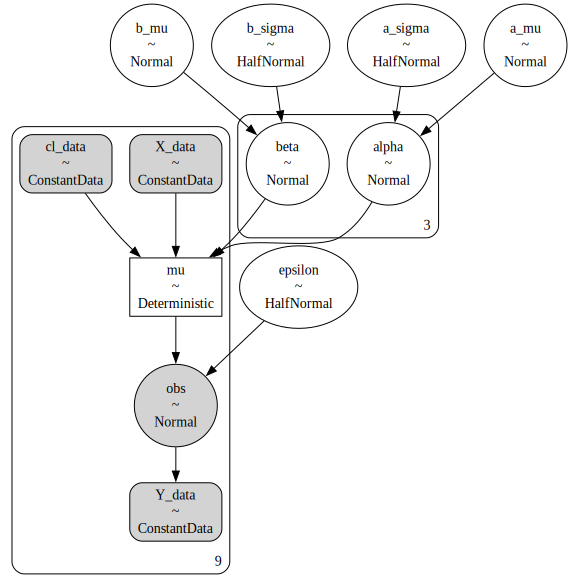

In [20]:
model3 = pm.Model()

with model3:
    # X, Yの観測値をConstantDataとして定義(通常ベイズと共通)
    X_data = pm.ConstantData('X_data', X)
    Y_data = pm.ConstantData('Y_data', Y)

    # クラス変数定義(階層ベイズ固有)
    cl_data = pm.ConstantData('cl_data', cl)

    # 確率変数alphaの定義(階層ベイズ固有)
    a_mu = pm.Normal('a_mu', mu=0.0, sigma=10.0)
    a_sigma = pm.HalfNormal('a_sigma',sigma=10.0)
    alpha = pm.Normal('alpha', mu=a_mu, sigma=a_sigma, shape=(3,))

    # 確率変数betaの定義(階層ベイズ固有)
    b_mu = pm.Normal('b_mu', mu=0.0, sigma=10.0)
    b_sigma = pm.HalfNormal('b_sigma', sigma=10.0)
    beta = pm.Normal('beta', mu=b_mu, sigma=b_sigma, shape=(3,))

    #　誤差epsilon(通常ベイスと共通)
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # muの値は、cl_dataによりindexを切り替えて計算(階層ベイズ固有)
    mu = pm.Deterministic('mu', X_data * alpha[cl_data] + beta[cl_data])

    # mu, epsilonを使って観測値用の確率モデルを定義(通常ベイスと共通)
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=Y_data)

g = pm.model_to_graphviz(model3)
display(g)

#### バージョンの確認

In [21]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

japanize_matplotlib: 1.1.3
pymc               : 5.11.0
pandas             : 2.2.1
matplotlib         : 3.8.3
arviz              : 0.17.1
seaborn            : 0.12.2
numpy              : 1.26.4

